<a href="https://colab.research.google.com/github/CelikAbdullah/my-deep-learning-notebooks/blob/main/image%20segmentation/Image_Segmentation_Oxford_Pets_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import random

# Getting the Oxford Pets dataset

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2022-06-17 10:58:50--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-06-17 10:58:50--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  29.6MB/s    in 27s     

2022-06-17 10:59:18 (28.1 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]



In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-06-17 10:59:21--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz [following]
--2022-06-17 10:59:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  14.1MB/s    in 1.3s    

2022-06-17 10:59:23 (14.1 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [4]:
!tar -xf images.tar.gz

In [5]:
!tar -xf annotations.tar.gz

# Prepare the data

In [6]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])
target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

# Show the data

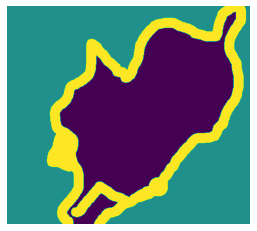

In [7]:
def display_target(target_array):
  # the original labels are 1,2 and 3. We subtract 1 so that the labels range from 0 to 2
  # and then we multiply by 127 so that the labels become 0(black), 127 (gray) and 254(near-white)
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:,:,0])

# we use color_mode="grayscale" so that the image we load is treated as having a single color channel
img = keras.utils.img_to_array(keras.utils.load_img(target_paths[9], color_mode="grayscale"))
display_target(img)


# Split the dataset

In [8]:
# we resize everything to 200x200
img_size = (200, 200)
# total number of samples in the data
num_imgs = len(input_img_paths)

# shuffle the file paths (they were originally sorted by breed)
# we use the same seed in both statements to ensure that the input paths and target paths stay in the same order
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return keras.utils.img_to_array(keras.utils.load_img(path, target_size=img_size))

def path_to_target(path):
    img = keras.utils.img_to_array(
        keras.utils.load_img(path, target_size=img_size, color_mode="grayscale"))
    # subtract 1 so that our labels become 0,1 and 2
    img = img.astype("uint8") - 1
    return img

# load all images in the input_imgs float32 array and their masks in the targets uint8 array (same order)
# the inputs have 3 channels (RBG values) and the targets have a single channel (which contains integer labels)
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# reseve 1000 samples for validation
num_val_samples = 1000

# split the data into a training and a validation set
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

# Build the model

In [9]:
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  # rescale input images to the [0-1] range
  x = keras.layers.Rescaling(1./255)(inputs)

  # use padding="same" in the conv layers to avoid the influence of border padding on feature map size
  x = keras.layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(256, 3, strides=2, activation="relu", padding="same")(x)
  x = keras.layers.Conv2D(256, 3, activation="relu", padding="same")(x)

  x = keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

  # we end the model with a per-pixel three-way softmax to classify each output pixel into one of our three categories
  outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

  model = keras.Model(inputs, outputs)
  return model

In [10]:
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

# Compile the model

In [11]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Define callback

In [12]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

# Train the model

In [13]:
history = model.fit(train_input_imgs, 
                    train_targets, 
                    epochs=50, 
                    callbacks=callbacks, 
                    batch_size=64, 
                    validation_data = (val_input_imgs, val_targets)
                    )

Epoch 1/50
100/100 [==============================] - 87s 672ms/step - loss: 1.1251 - val_loss: 0.8767
Epoch 2/50
100/100 [==============================] - 63s 627ms/step - loss: 0.9260 - val_loss: 0.9016
Epoch 3/50
100/100 [==============================] - 65s 649ms/step - loss: 0.8361 - val_loss: 0.8271
Epoch 4/50
100/100 [==============================] - 65s 652ms/step - loss: 0.7818 - val_loss: 1.0416
Epoch 5/50
100/100 [==============================] - 65s 654ms/step - loss: 0.7156 - val_loss: 0.6633
Epoch 6/50
100/100 [==============================] - 65s 650ms/step - loss: 0.6500 - val_loss: 0.9225
Epoch 7/50
100/100 [==============================] - 65s 649ms/step - loss: 0.6167 - val_loss: 0.6011
Epoch 8/50
100/100 [==============================] - 65s 650ms/step - loss: 0.5934 - val_loss: 0.5385
Epoch 9/50
100/100 [==============================] - 65s 651ms/step - loss: 0.5630 - val_loss: 0.6452
Epoch 10/50
100/100 [==============================] - 65s 652ms/step - l

# Plot the result

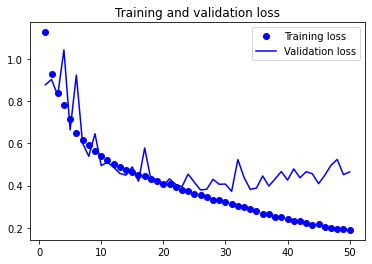

In [14]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

# Load best model

In [15]:
model = keras.models.load_model("oxford_segmentation.keras")

# Predict a segmentation mask

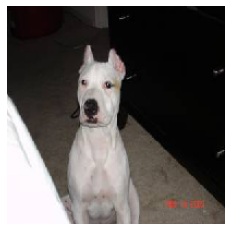

In [17]:
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(keras.utils.array_to_img(test_image))

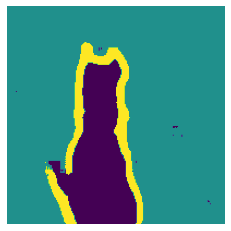

In [18]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)